In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import gc
import re
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import copy
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)
from nltk.tokenize import TweetTokenizer
import string
import emoji
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hatespeech/train.csv
/kaggle/input/hate-speech-detection/sample_submission.csv
/kaggle/input/hate-speech-detection/train.csv
/kaggle/input/hate-speech-detection/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/hatespeech/train.csv")
#train_df = train_df.rename(columns={'HS': 'Hate Speech', 'TR': 'Targeted', 'AG': 'Aggressive'})

# Print the first few rows to verify the changes
print(train_df.head())

# traindf, val_df = train_test_split(df, test_size=0.05)
# traindf.shape, val_df.shape

     id                                               text  HS  TR  AG
0  6452  @indigomermaidd You're the exception , you wer...   1   1   0
1  4884  If a woman doesn't want you just unleash your ...   1   0   0
2  1931  Son of Jamestown, Protestants that made the US...   0   0   0
3  4942  Literally just got hit by a car bc this dumb b...   1   1   0
4  4721  charli: fuck you bitch charli: omg why am i so...   1   1   0


In [3]:
emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']
dic = {'HS':'Hate Speech', 'TR' : 'Targeted', 'AG' : 'Aggressive'}

def tokenize(tweet):
    # instantiate the tokenizer class
    tokenizer = TweetTokenizer(preserve_case=False, 
                              strip_handles=True,
                              reduce_len=True)

    # tokenize the tweets
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens: # Go through every word in your tokens list
        if word not in string.punctuation:  # remove punctuation
            tweets_clean.append(word)
    result = tweets_clean
    return " ".join(result)

def preprocess(tweet):
    result = tweet.replace('rt @','@')
    result = result.replace('@','<user> @')
    # it will remove hyperlinks
    result = re.sub(r'https?:\/\/.*[\r\n]*', '<url>', result)

    # it will remove hashtags. We have to be careful here not to remove 
    # the whole hashtag because text of hashtags contains huge information. 
    # only removing the hash # sign from the word
    result = re.sub(r'#', '<hashtag>', result)

    # Replace multiple dots with space
    result = re.sub('\.\.+', ' ', result) 

    for char in result:
        if emoji.is_emoji(char):
            result = result.replace(char, "<emoticon >")
    for emo in emoticons:
        result = result.replace(emo, "<emoticon >")

    result = tokenize(result)
    # it will remove single numeric terms in the tweet. 
    result = re.sub(r'[0-9]+', '<number>', result)
    result = re.sub(r'<number>\s?st', '<number>', result)
    result = re.sub(r'<number>\s?nd', '<number>', result)
    result = re.sub(r'<number>\s?rd', '<number>', result)
    result = re.sub(r'<number>\s?th', '<number>', result)

    return result

def clean_abstract(text):
    # Apply the preprocessing steps to the provided text
    result = preprocess(text.lower())
    return result

def get_texts(df):
    texts = 'multilabel classification: ' + df['text'].apply(clean_abstract)
    texts = texts.values.tolist()
    return texts


def get_labels(df):
    labels_li = [' '.join(x.split()) for x in df.columns.to_list()[2:]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, 2:].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels


texts = get_texts(train_df)
labels = get_labels(train_df)

for text, label in zip(texts[:5], labels[:5]):
    print(f'TEXT -\t{text}')
    print(f'LABEL -\t{label}')
    print()

TEXT -	multilabel classification: <user> you're the exception you weren't a rude lil cunt like some hoes emoticon emoticon
LABEL -	HS , TR </s>

TEXT -	multilabel classification: if a woman doesn't want you just unleash your charm women are weak and will cave after almost nothing
LABEL -	HS </s>

TEXT -	multilabel classification: son of jamestown protestants that made the usa and conservative for president trump you can stick lincoln the guy that used fed troops against citizens and imposed tariffs and taxes on the souths cotton it was written by irish catholic immigrant formerly a never trumper <url>
LABEL -	none </s>

TEXT -	multilabel classification: literally just got hit by a car bc this dumb blonde bitch was on her phone and she didn't even stop after hahahaha what a cunt
LABEL -	HS , TR </s>

TEXT -	multilabel classification: charli fuck you bitch charli omg why am i so extra wjahjaaj
LABEL -	HS , TR </s>



/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


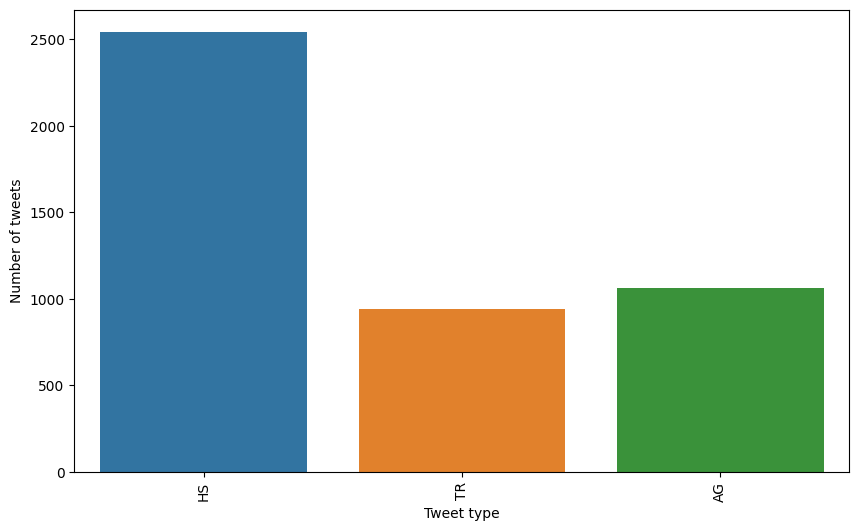

In [4]:
categories = train_df.columns.to_list()[2:]

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=categories, y=train_df.iloc[:, 2:].sum().values)
plt.ylabel('Number of tweets')
plt.xlabel('Tweet type')
plt.xticks(rotation=90)
plt.show()

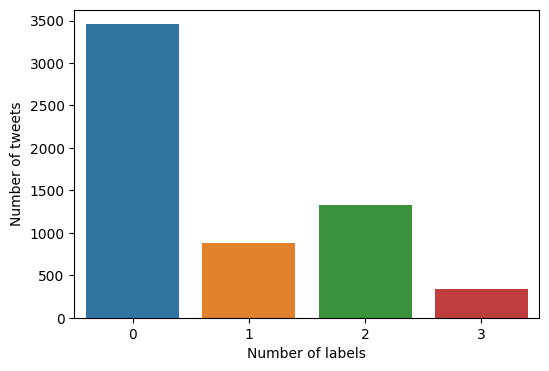

In [5]:
row_sums = train_df.iloc[:, 2:].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=multilabel_counts.index,y= multilabel_counts.values)
plt.ylabel('Number of tweets')
plt.xlabel('Number of labels')
plt.show()

In [6]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 250
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 1

config = Config()

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
class T5Dataset(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [8]:
np.random.seed(config.SEED)

dataset_size = len(train_df)
indices = list(range(dataset_size))
split = int(np.floor(config.VALIDATION_SPLIT * dataset_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [9]:
train_data = T5Dataset(train_df, train_indices)
val_data = T5Dataset(train_df, val_indices)

train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)

b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 250])
src_attention_mask shape: torch.Size([16, 250])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:309: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [10]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

In [11]:
device = config.DEVICE
device

device(type='cuda')

In [12]:
def get_ohe(x):
    labels_li = ['_'.join(x.split()) for x in train_df.columns.to_list()[2:]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx
        
    y = [labels.split(', ') for labels in x]
    ohe = []
    for labels in y:
        temp = [0] * 3
        for label in labels:
            idx = labels_li_indices.get(label, -1)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe

In [13]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                labels=labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        labels = batch['tgt_input_ids'].to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        labels=labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [14]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score

In [15]:
model = T5Model()
model.to(device);

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [16]:
best_model, best_val_micro_f1_score = run()

Epoch 0:   0%|          | 0/282 [00:00<?, ?it/s]

-- Step: 0


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:   0%|          | 1/282 [01:05<5:08:46, 65.93s/it]

Val loss: 7.770918546838963
Val accuracy: 0.7191460973982655
Val micro f1 score: 0.0


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:309: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0: 100%|██████████| 282/282 [03:30<00:00,  1.34it/s]


Training loss: 0.995717557715186


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Val loss: 0.3682355761845061
Val accuracy: 0.7191460973982655
Val micro f1 score: 0.0
--- Best Model. Val loss: -inf -> 0.0


In [17]:
test_df = pd.read_csv('/kaggle/input/hate-speech-detection/test.csv')
dataset_size = len(test_df)
test_indices = list(range(dataset_size))

test_data = T5Dataset(test_df, test_indices, set_type='test')
test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)

In [18]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    pred_ohe = get_ohe(pred)
    return pred_ohe

pred_ohe = predict(best_model)

  0%|          | 0/125 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 125/125 [00:29<00:00,  4.26it/s]


In [19]:
print(pred_ohe)

[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [20]:
sample_submission = pd.read_csv('/kaggle/input/hate-speech-detection/sample_submission.csv')

# Reshape the 'id' column
ids = sample_submission['id'].values.reshape(-1, 1)

# Assuming pred_ohe is your predicted output in one-hot encoded format
# It should have the shape (N, M), where N is the number of samples and M is the number of classes

# Check the shapes to ensure they match
print("ids shape:", ids.shape)
print("pred_ohe shape:", pred_ohe.shape)

# Concatenate the arrays along the second axis (axis=1)
merged = np.concatenate((ids, pred_ohe), axis=1)

# Create a DataFrame from the merged array
submission = pd.DataFrame(merged, columns=sample_submission.columns).astype(int)

# Print the submission DataFrame
print(submission)

ids shape: (10, 1)
pred_ohe shape: (2000, 3)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10 and the array at index 1 has size 2000

In [ ]:
submission_fname = f't5_microf1-{round(best_val_micro_f1_score, 4)}.csv'
submission.to_csv('/kaggle/working/' + submission_fname, index=False)